<a href="https://colab.research.google.com/github/vikadenisova/mirea_ml/blob/main/ML_lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [69]:
import numpy as np
import struct
from functools import reduce
from scipy.optimize import minimize
from matplotlib import pyplot as plt

In [70]:
# Вам предлагается обучить трехслойную нейронную сеть прямого распространения с сигмоидальными функциями активации на
# наборе данных MNIST - множестве изображений рукописных цифр и соответствующих метках 0-9.

# Ваша задача заполнить код в следующих функциях:
# logistic - вычисляет логистическую функцию от аргумента,
# compute_hypothesis - вычисляет выходы сети для заданного набора данных,
# compute_cost - вычисляет функцию стоимости,
# compute_cost_grad - вычисляет градиент функции стоимости с помощью алгоритма обратного распространения ошибки.

# По ходу работы смотрите в консоль. Там будут выводиться результаты написанных вами функций и ожидаемые результаты.
# Так вы сможете проверить себя.

# Ниже заданы "константы", с которыми можно "поиграть" - поварьировать их и посмотреть, что будет.
HIDDEN_LAYER_SIZE = 20  # Количество нейронов в скрытом слое.

# Всего у вас есть 60 000 изображений, поэтому сумма следующих двух констант не должна быть больше 60 000.
SAMPLES_TO_TRAIN = 2000  # Количество примеров в обучающей выборке, на ней будет производить подбор параметров модели.
SAMPLES_TO_TEST = 200  # Количество примеров в тестовой выборке, на ней будет оцениваться качество модели.

In [71]:
def one_hot_encode(y):

    # Функция кодирует вектор чисел с метками классов в матрицу, каждая строка которой является унитарным кодом
    # соответствующей метки.

    return np.array(np.arange(0, 10, 1) == y, dtype=np.int32)

In [72]:
def get_random_matrix(l_in, l_out):

    # Функция для генерации матрицы случайных параметров.

    return np.random.uniform(-0.5, 0.5, (l_out, l_in + 1))

In [73]:
def compute_cost_grad_approx(X, y, theta, lamb):

    # Фукнция для численного расчета градиента фукници стоимости. Такой метод полезно использовать при проверке
    # правильности аналитического расчета.

    eps = 1e-5
    grad = np.zeros(theta.size)
    perturb = np.zeros(theta.size)
    for i in range(theta.shape[0]):
        if i % 1000 == 0:
            print(f'{round(i / theta.shape[0] * 100, 2)}%')
        perturb[i] = eps
        grad[i] = (compute_cost(X, y, theta + perturb, lamb) - compute_cost(X, y, theta - perturb, lamb)) / (2 * eps)
        perturb[i] = 0
    return grad

In [74]:
def logistic(z):

    # Функция принимает аргумент z - скаляр, вектор или матрицу в виде объекта numpy.array()
    # Должна возвращать скяляр, вектор или матрицу (в зависимости от размерности z)
    # результатов вычисления логистической функции от элементов z

    # ВАШ КОД ЗДЕСЬ
    result = 1/(1 + np.exp(-z))
    # =============

    return result

In [75]:
def logistic_grad(z):

    # Функция принимает аргумент z - скаляр, вектор или матрицу в виде объекта numpy.array()
    # Должна возвращать скяляр, вектор или матрицу (в зависимости от размерности z)
    # результатов вычисления производной логистической функции от элементов z


    # ВАШ КОД ЗДЕСЬ
    result = logistic(z) * (1 - logistic(z))
    # =============

    return result

In [76]:
def compute_hypothesis(X, theta):

    # Функция принимает матрицу данных X без фиктивного признака и вектор параметров theta.
    # Вектор theta является "разворотом" мартиц Theta1 и Theta2 в плоский вектор.
    # Функция должна возвращать матрицу выходов сети для каждого примера из обучающего набора,
    # а также матрицу входов нейронов скрытого слоя и матрицу выходов скрытого слоя (это понадобится для реализации
    # алгоритма обратного распространения ошибки).

    # Восстановление матриц Theta1 и Theta2 из вектора theta:
    Theta1 = theta[:HIDDEN_LAYER_SIZE * (X.shape[1] + 1)].reshape(HIDDEN_LAYER_SIZE, X.shape[1] + 1)
    Theta2 = theta[HIDDEN_LAYER_SIZE * (X.shape[1] + 1):].reshape(10, HIDDEN_LAYER_SIZE + 1)

    # H матрица выходов
    # Z2 матрица входов скрытого слоя
    # A2 матрица выходов скрытого слоя

    # ВАШ КОД ЗДЕСЬ

    Z2 = np.column_stack((np.ones(X.shape[0]), X)) @ Theta1.T
    A2 = logistic(Z2)
    
    Z3 = np.column_stack((np.ones(A2.shape[0]), A2)) @ Theta2.T
    H = logistic(Z3)

    # =============

    return H, Z2, A2

In [77]:
def compute_cost(X, y, theta, lamb):

    # Функция принимает матрицу данных X без фиктивного признака, вектор верных классов y,
    # вектор параметров theta и параметр регуляризации lamb.
    # Вектор theta является "разворотом" мартиц Theta1 и Theta2 в плоский вектор.
    # Должна вернуть значение функции стоимости в точке theta.

    m, n = X.shape  # m - количество примеров в выборке, n - количество признаков у каждого примера
    cost = 0  # значение функции стоимости при заданных параметрах, его нужно посчитать

    # Восстановление матриц Theta1 и Theta2 из ветора theta:
    Theta1 = theta[:HIDDEN_LAYER_SIZE * (X.shape[1] + 1)].reshape(HIDDEN_LAYER_SIZE, X.shape[1] + 1)
    Theta2 = theta[HIDDEN_LAYER_SIZE * (X.shape[1] + 1):].reshape(10, HIDDEN_LAYER_SIZE + 1)

    # ВАШ КОД ЗДЕСЬ
    H, Z2, A2 = compute_hypothesis(X, theta)
    for i in range(1,m):
        y2 = one_hot_encode(y[i])
        for k in range(1,H.shape[1]):
            cost = cost - y2[k] * np.log(H[i][k]) - (1 - y2[k]) * np.log(1 - (H[i][k]))
    sum_theta = np.sum(Theta1**2) + np.sum(Theta2**2)
    cost = (cost + lamb*sum_theta/2)/m
    # ==============

    return cost

In [78]:
def compute_cost_grad(X, y, theta, lamb):

    # Функция принимает матрицу данных X без фиктивного признака, вектор верных классов y,
    # вектор параметров theta и параметр регуляризации lamb.
    # Вектор theta является "разворотом" мартиц Theta1 и Theta2 в плоский вектор.
    # Функция должна реализовать алгоритм обратного распространения ошибки и вернуть матрицы градиентов весов связей.

    m, n = X.shape  # m - количество примеров в выборке, n - количество признаков у каждого примера

    # Восстановление матриц Theta1 и Theta2 из ветора theta:
    Theta1 = theta[:HIDDEN_LAYER_SIZE * (X.shape[1] + 1)].reshape(HIDDEN_LAYER_SIZE, X.shape[1] + 1)
    Theta2 = theta[HIDDEN_LAYER_SIZE * (X.shape[1] + 1):].reshape(10, HIDDEN_LAYER_SIZE + 1)

    # Theta1_grad матрица градиентов весов между входным и скрытым слоем, ее нужно заполнить
    # Theta2_grad матрица градиентов весов между скрытым и выходным слоем, ее нужно заполнить

    # ВАШ КОД ЗДЕСЬ
    H, Z2, A2 = compute_hypothesis(X, theta)
    y_end = np.array([one_hot_encode(i) for i in y])
    delta3 = H - y_end

    delta2 = []
    A2_ones = np.column_stack((np.ones(X.shape[0]), A2))
    X_ones = np.column_stack((np.ones(X.shape[0]), X))

    for i in range(delta3.shape[0]):
        temp = (Theta2.T @ delta3[i]) * logistic_grad(np.column_stack((np.ones(X.shape[0]), Z2))[i])
        delta2.append(temp)
    
    delta2 = np.array(delta2)

    delta1_big = []
    delta2_new = []
    for i in range(delta2.shape[0]):
        delta2_new.append(delta2[i][1:])

    delta1_big = X_ones.T @ delta2_new
    delta2_big = A2_ones.T @ delta3
    
    delta1_big = delta1_big.T + lamb * Theta1
    delta2_big = delta2_big.T + lamb * Theta2

    for i in range(delta1_big.shape[0]):
        delta1_big[i][0] = delta1_big[i][0] - lamb * Theta1[i][0]
    
    for i in range(delta2_big.shape[0]):
        delta2_big[i][0] = delta2_big[i][0] - lamb * Theta2[i][0]

    Theta1_grad = delta1_big/m
    Theta2_grad = delta2_big/m

    # ==============

    return np.concatenate((Theta1_grad, Theta2_grad), axis=None)

In [79]:
def load_data_idx(file_path):
    with open(file_path, 'rb') as input_file:
        magic = input_file.read(4)
        dims = int(magic[3])
        sizes = [struct.unpack('>L', input_file.read(4))[0] for _ in range(dims)]
        size = reduce(lambda x, y: x * y, sizes)
        data = np.array(list(input_file.read(size)), dtype=float)
        data = data.reshape(sizes)
        return data

In [80]:
# Загрузка данных
images = load_data_idx('images.idx')
features = images.reshape((images.shape[0], images.shape[1] * images.shape[2])) / 128 - 1.0

labels = load_data_idx('labels.idx')

In [81]:
X = features[:SAMPLES_TO_TRAIN]
y = labels[:SAMPLES_TO_TRAIN]

In [82]:
X_test = features[SAMPLES_TO_TRAIN: SAMPLES_TO_TRAIN + SAMPLES_TO_TEST]
y_test = labels[SAMPLES_TO_TRAIN: SAMPLES_TO_TRAIN + SAMPLES_TO_TEST]

In [83]:
print(f'logistic(0) = {logistic(np.array(0))} (должно быть 0.5)\n'
      f'logistic(-10) = {logistic(np.array(-10))} (должно быть ~0)\n'
      f'logistic(10) = {logistic(np.array(10))} (должно быть ~1)')
print()
print(f'logistic_grad(0) = {logistic_grad(np.array(0))} (должно быть ~0.25)\n'
      f'logistic_grad(-10) = {logistic_grad(np.array(-10))} (должно быть ~0)\n'
      f'logistic_grad(10) = {logistic_grad(np.array(10))} (должно быть ~0)')

logistic(0) = 0.5 (должно быть 0.5)
logistic(-10) = 4.5397868702434395e-05 (должно быть ~0)
logistic(10) = 0.9999546021312976 (должно быть ~1)

logistic_grad(0) = 0.25 (должно быть ~0.25)
logistic_grad(-10) = 4.5395807735951673e-05 (должно быть ~0)
logistic_grad(10) = 4.5395807735907655e-05 (должно быть ~0)


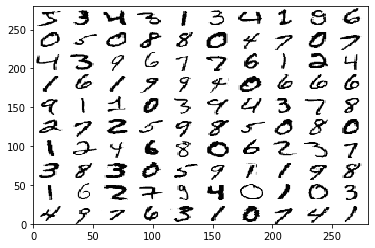

In [84]:
im_size = int(features.shape[1] ** 0.5)
hm = np.zeros((im_size * 10, im_size * 10))
for i in range(100):
    im_x = i % 10 * im_size
    im_y = i // 10 * im_size
    for j in range(features.shape[1]):
        px_x = im_x + j % im_size
        px_y = im_y + j // im_size
        hm[10 * im_size - 1 - px_x, px_y] = images[i, j % im_size, j // im_size]
plt.pcolor(hm, cmap='Greys')
plt.show()

In [85]:
lamb = 0.5  # можно поварьировать параметр регуляризации и посмотреть, что будет

In [86]:
init_Theta1 = np.random.uniform(-0.12, 0.12, (HIDDEN_LAYER_SIZE, X.shape[1] + 1))
init_Theta2 = np.random.uniform(-0.12, 0.12, (10, HIDDEN_LAYER_SIZE + 1))

In [87]:
init_theta = np.concatenate((init_Theta1, init_Theta2), axis=None)

In [88]:
back_prop_grad = compute_cost_grad(X[:10], y[:10], init_theta, 0)

In [89]:
print('Запуск численного расчета градиента (может занять какое-то время)')
num_grad = compute_cost_grad_approx(X[:10], y[:10], init_theta, 0)

Запуск численного расчета градиента (может занять какое-то время)
0.0%
6.29%
12.57%
18.86%
25.14%
31.43%
37.71%
44.0%
50.28%
56.57%
62.85%
69.14%
75.42%
81.71%
87.99%
94.28%


In [90]:
print('Градиент, посчитанный аналитически: ')
print(back_prop_grad)

Градиент, посчитанный аналитически: 
[ 0.00861789 -0.00861789 -0.00861789 ...  0.19743951  0.3526936
  0.37414111]


In [91]:
print('Градиент, посчитанный численно (должен примерно совпадать с предыдущим): ')
print(num_grad)

Градиент, посчитанный численно (должен примерно совпадать с предыдущим): 
[ 0.00861789 -0.00861789 -0.00861789 ...  0.19743951  0.3526936
  0.37414111]


In [92]:
print()
print('Относительное отклоение градиентов (должно быть < 1e-7): ')
print((np.linalg.norm(back_prop_grad - num_grad) / np.linalg.norm(back_prop_grad + num_grad)))


Относительное отклоение градиентов (должно быть < 1e-7): 
2.4670754246135436e-09


In [93]:
print()
print('Запуск оптимизации параметров сети (может занять какое-то время)')
opt_theta_obj = minimize(lambda th: compute_cost(X, y, th, lamb), init_theta,
                         method='CG',
                         jac=lambda th: compute_cost_grad(X, y, th, lamb),
                         options={'gtol': 1e-3, 'maxiter': 3000, 'disp': False})


Запуск оптимизации параметров сети (может занять какое-то время)


In [94]:
print('Минимизация функции стоимости ' + ('прошла успешно.' if opt_theta_obj.success else 'не удалась.'))

Минимизация функции стоимости прошла успешно.


In [95]:
opt_theta = opt_theta_obj.x
print('Функция стоимости при оптимальных параметрах (должна быть < 0.5): ')
print(compute_cost(X, y, opt_theta, lamb))

Функция стоимости при оптимальных параметрах (должна быть < 0.5): 
0.34928857985898387


In [96]:
hypos_train = compute_hypothesis(X, opt_theta)[0]

In [97]:
true_preds_train_num = 0
for k in range(hypos_train.shape[0]):
    max_el = np.max(hypos_train[k, :])
    true_preds_train_num += list(np.array(hypos_train[k, :] == max_el, dtype=np.int32)) == list(one_hot_encode(y[k]))
print('Доля верно распознаных цифр в обучающем наборе:', true_preds_train_num / hypos_train.shape[0] * 100, '%')

Доля верно распознаных цифр в обучающем наборе: 98.6 %


In [98]:
hypos_test = compute_hypothesis(X_test, opt_theta)[0]

In [99]:
true_preds_test_num = 0
for k in range(hypos_test.shape[0]):
    max_el = np.max(hypos_test[k, :])
    true_preds_test_num += list(np.array(hypos_test[k, :] == max_el, dtype=np.int32)) == list(one_hot_encode(y_test[k]))
print('Доля верно распознаных цифр в тестовом наборе:', true_preds_test_num / hypos_test.shape[0] * 100, '%')

Доля верно распознаных цифр в тестовом наборе: 85.0 %


In [100]:
if HIDDEN_LAYER_SIZE ** 0.5 % 1.0 == 0:
    Theta1 = opt_theta[:HIDDEN_LAYER_SIZE * (X.shape[1] + 1)].reshape(HIDDEN_LAYER_SIZE, X.shape[1] + 1)
    Theta1 = Theta1[:, 1:]
    Theta1 = (Theta1 - Theta1.mean(axis=0)) / (Theta1.std(axis=0))
    Theta1 = Theta1.reshape(HIDDEN_LAYER_SIZE, 28, 28)
    im_size = int(features.shape[1] ** 0.5)
    size_imgs = int(HIDDEN_LAYER_SIZE ** 0.5)
    hm = np.zeros((im_size * size_imgs, im_size * size_imgs))
    for i in range(HIDDEN_LAYER_SIZE):
        im_x = i % size_imgs * im_size
        im_y = i // size_imgs * im_size
        for j in range(features.shape[1]):
            px_x = im_x + j % im_size
            px_y = im_y + j // im_size
            hm[size_imgs * im_size - 1 - px_x, px_y] = Theta1[i, j % im_size, j // im_size]
    plt.pcolor(hm, cmap='Greys')
    plt.show()
